#Machine Learning Team Project by Max Needle, Vincent Lo, Ranee Patel, Lucius Pham, and Mengshi Wang

## SIOP Competition

Our team entered the annual machine learning competition run by the Society for Industrial Organizational Psychology (SIOP). Using Walmart candidate screening data, we sought to predict which half of a development (test) applicant pool would represent the highest amount of true High Performers (worth 25% of our final score), the highest amount of true Retained employees (worth 25% of our final score), and the highest amount of both true Retained High Performers (worth 50% of our final score). We also had to account for adverse impact, the difference in hiring rates between Protected applicants (belonging to any of a number of protected classes) and Non-Protected applicants, as a penalty for "unfairness" in our selection method would be subtracted from our final score.

In this notebook, we detail two strategies that we employed. First, we created a binary variable for whether a candidate was both Retained and a High Performer (1) or not (0). We only used the subset of training data in which both of these variables were known in addition to whether they belonged to a Protected group or not. 

Then we separated this training dataset into two groups: Protected and Non-Protected (as per Dr. Squires' suggestion). For each of the two groups, we imputed missing data in three different ways (mean, median, and KNN with 10 neighbors), giving us 3 imputed datasets for each of the two groups. Then we used five-fold cross-validation on multiple models and we found the best performing model for each of the 2 groups (across all three imputations) according to the AUC of the models. 

In the first strategy, we used the top performing models to predict the probability that a Protected applicant and a Non-Protected applicant (separately based on their individual best models) would be a "Retained High Performer". 

In order to determine which half of this training applicant pool should be hired, we used their predicted probabilities of being a "Retained High Performer" to find the combination of Protected and Non-Protected applications which would result in the highest final score. We then created a new Hire/Not Hire variable, on which this half of the applicant pool were deemed as hires and the rest were not. Finally, we trained the development (test) applicant pool based on this Hire/Not Hire variable and chose the top 50% of that pool with the highest probability of being hires. We then submitted our hiring determinations to the competition organizers, and we were told that this strategy earned a final score of 46.1747. 

In the second strategy, we decided to use the top performing models for Protected and Non-Protected training applicants to directly predict the probability that a development Protected applicant and a development Non-Protected applicant (separately based on their individual best models) would be a Retained High Performer. In order to determine which half of this development applicant pool should be hired, we used their predicted probabilities of being Retained High Performers to find the combination of Protected and Non-Protected applicants which would result in the highest final score. We then submitted our hiring determinations to the competition organizers, and we were told that this strategy earned a final score of 56.5861.

The higher of these two final scores, 56.5861, put us at 16th out of 24 teams on the leaderboard in the competition at the time of submission.

## Import early packages and set up display options

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# set max view
pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 100000)

## Import training dataset, isolate instances with all necessary DVs ("Retained", "High_Performer", and "Protected_Group"), and create binary variable of "Retained_High_Performer"

In [3]:
#Link the dataset from github

url_train = 'https://github.com/vl1146/SIOP2020ML/blob/master/train.xlsx?raw=true'

# import data and drop columns with id and unhelpful criterion values

data = pd.read_excel((url_train), na_values= ' ')

In [4]:
# isolate 7890 instances with data all necessary DVS
training = data[((data['Retained'].notnull()) & (data['High_Performer'].notnull()) & (data['Protected_Group'].notnull()))]

In [5]:
# create "Retained_High_Performer"
training['Retained_High_Performer']= [1 if ((training.iloc[row,6]==1) & (training.iloc[row,8]==1)) else 0 for row in range(len(training))]

B:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Split training dataset based on "Protected_Group" (Protected and Non-Protected) and impute missing values with mean, median, and KNN with 10 neighbors (using knn.impute in the bnstruct package in R) separately to produce three different imputed datasets for each group (Protected and Non-Protected)


In [6]:
# split training data into Protected and Non-Protected
protected = training[training['Protected_Group']==1].reset_index()
non_protected = training[training['Protected_Group']==0].reset_index()

In [7]:
# impute features of Protected with mean, median, and KNN
protected_X = protected.loc[:, 'SJ_Most_1':'PScale13_Q5']

mean_protected_X = protected_X.fillna(protected_X.mean())
median_protected_X = protected_X.fillna(protected_X.median())

# protected_X.to_excel('protected_X_to_impute.xlsx', index = False)

# this is the code I ran in R to impute KNN
# library(readxl)
# X_to_impute <- read_excel("protected_X_to_impute.xlsx")
# library(bnstruct)
# KNN_X = knn.impute(as.matrix(X_to_impute), k= 10)
# library(writexl)
# write_xlsx(as.data.frame(KNN_X), "~/Desktop/SIOP Analysis/protected_X_imputed.xlsx")

url_KNNp = 'https://github.com/vl1146/SIOP2020ML/blob/master/protected_X_imputed.xlsx?raw=true'

KNN_protected_X= pd.read_excel(url_KNNp)

In [8]:
# impute features of Protected with mean, median, and KNN
non_protected_X = non_protected.loc[:, 'SJ_Most_1':'PScale13_Q5']

mean_non_protected_X = non_protected_X.fillna(non_protected_X.mean())
median_non_protected_X = non_protected_X.fillna(non_protected_X.median())

# non_protected_X.to_excel('non_protected_X_to_impute.xlsx', index = False)

# this is the code I ran in R to impute KNN
# library(readxl)
# X_to_impute <- read_excel("non_protected_X_to_impute.xlsx")
# library(bnstruct)
# KNN_X = knn.impute(as.matrix(X_to_impute), k= 10)
# library(writexl)
# write_xlsx(as.data.frame(KNN_X), "~/Desktop/SIOP Analysis/non_protected_X_imputed.xlsx")

url_KNNnp = 'https://github.com/vl1146/SIOP2020ML/blob/master/non_protected_X_imputed.xlsx?raw=true'

KNN_non_protected_X= pd.read_excel(url_KNNnp)

## PROTECTED: Using 5-fold cross-validation on multiple models (5 Logistic Regression, 1 Naive Bayes, 1 Decision Tree, 6 Random Forests, 1 Support Vector Machine, 48 Neural Networks, 3 KNN models, and 1 XGBoost), find the best performing model for the Protected group (across all three imputations) according to the AUC of the models.

In [11]:
# define function for running multiple models
from sklearn.model_selection import cross_validate
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


# this model takes an (imputed) X dataframe, a y variable, and the type of imputation (String)
def cross_validated_models(X, y, X_imputation):
    
    X = X.apply(zscore)

    # create a dataframe to hold the model results
    df = pd.DataFrame(columns= ['Model','Parameters', 'Accuracy', 'Recall','ROC_AUC'])
        
    # logistic regression
    model = "Logistic Regression"
    # for each of 5 solver parameters
    solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    for s in solvers:
        # run 5 logistic regression models with the normalized X dataframe and average the cross validation scores
        score = pd.DataFrame(cross_validate(LogisticRegression(solver = s, max_iter=1000, random_state=0), X, y, cv=5, scoring = ['recall','accuracy','roc_auc']))[['test_accuracy','test_recall','test_roc_auc']].mean()
        # add model results to the overall dataframe
        df = df.append({'Model': model,'Parameters': 'solver: '+s, 'Accuracy': score[0],'Recall': score[1], 'ROC_AUC': score[2]}, ignore_index = True)  

    # naive bayes
    model = "Naive Bayes"
    # run 5 naive bayes models with the X dataframe and average the cross validation scores
    score = pd.DataFrame(cross_validate(GaussianNB(), X, y, cv=5, scoring = ['recall','accuracy','roc_auc']))[['test_accuracy','test_recall','test_roc_auc']].mean()
    # add model results to the overall dataframe
    df = df.append({'Model': model,'Parameters': 'none', 'Accuracy': score[0],'Recall': score[1], 'ROC_AUC': score[2]}, ignore_index = True)

    # decision tree
    model = "Decision Tree"    
    score = pd.DataFrame(cross_validate(tree.DecisionTreeClassifier(random_state=0), X, y, cv=5, scoring = ['recall','accuracy','roc_auc']))[['test_accuracy','test_recall','test_roc_auc']].mean()
    df = df.append({'Model': model,'Parameters': 'none', 'Accuracy': score[0],'Recall': score[1], 'ROC_AUC': score[2]}, ignore_index = True)

    # random forest
    model = "Random Forest"
    # for each of 5 n_estimator parameters
    estimators = [150,300,450,600,750,900,1050]
    max_features = [.2,'sqrt','log2']
    for e in estimators:
      for m in max_features:
        score = pd.DataFrame(cross_validate(rfc(n_estimators=e, max_features=m, random_state=0), X, y, cv=5, scoring = ['recall','accuracy','roc_auc']))[['test_accuracy','test_recall','test_roc_auc']].mean()
        df = df.append({'Model': model,'Parameters': 'n_estimators: '+str(e), 'Accuracy': score[0],'Recall': score[1], 'ROC_AUC': score[2]}, ignore_index = True)

    # support vector machine
    model = "Support Vector Machine"
    # run 1 linear SVM models with the X dataframe and average the cross validation scores
    score = pd.DataFrame(cross_validate(LinearSVR(random_state=0), X, y, cv=5, scoring = 'roc_auc')).mean()['test_score']
    df = df.append({'Model': model,'Parameters': 'none', 'Accuracy': np.nan,'Recall': np.nan, 'ROC_AUC': score}, ignore_index = True)

    # neural networks
    model = "Neural Network"
    # for each of 4 hidden_layer_size parameters
    hidden_layer_sizes=[(120,),(120,120),(120,120,120),(120,120,120,120)]
    # for each of 4 activation parameters
    activation= ['identity', 'logistic', 'tanh', 'relu']
    # for each of 3 solver parameters
    solver = ['lbfgs', 'sgd', 'adam']
    for h in hidden_layer_sizes:
        for a in activation:
            for s in solver:
                # run 2 neural net models with the X dataframe and average the cross validation scores
                score = pd.DataFrame(cross_validate(MLPClassifier(hidden_layer_sizes = h, activation = a, solver = s, max_iter= 1000, random_state=0), X, y, cv=5, scoring = ['recall','accuracy','roc_auc']))[['test_accuracy','test_recall','test_roc_auc']].mean()
                df = df.append({'Model': model,'Parameters': 'hidden_layer_sizes: '+str(h)+' & activation: '+a+' & solver: '+s, 'Accuracy': score[0],'Recall': score[1], 'ROC_AUC': score[2]}, ignore_index = True)

    # KNN
    model = "KNN"
    # for each of 3 n_neighbor parameters
    neighbors = [3,5,10]
    for n in neighbors:
        # run 5 KNN models with the X dataframe and average the cross validation scores
        
        score = pd.DataFrame(cross_validate(KNeighborsClassifier(n_neighbors=n), X, y, cv=5, scoring = ['recall','accuracy','roc_auc']))[['test_accuracy','test_recall','test_roc_auc']].mean()
        df = df.append({'Model': model,'Parameters': 'n_neighbors: '+str(n), 'Accuracy': score[0],'Recall': score[1], 'ROC_AUC': score[2]}, ignore_index = True)

    #XGBoost
    model ="XGBoost"
    # for each of 3 learning_rate parameters
    learning_rate = [.01, .03, .05]
    # for each of 3 n_estimators parameters
    n_estimators = [100, 300, 500]
    # for each of 3 max_depth parameters
    max_depth = [5, 10, 15]
    # for each of 3 min_child_weight parameters
    min_child_weight = [1, 3, 5]
    # for each of 3 gamma parameters
    gamma = [.1, .2, .3]
    for l in learning_rate:
        for n in n_estimators:
            for m in max_depth:
                for c in min_child_weight:
                    for g in gamma:
                        score = pd.DataFrame(cross_validate(xgb.XGBClassifier(subsample=.8, colsample_bytree=.8, reg_alpha=1e-5, learning_rate=l, n_estimators=n, max_depth=m, child_weight=c, gamma=g, random_state=0), X, y, cv=5, scoring = ['recall','accuracy','roc_auc']))[['test_accuracy','test_recall','test_roc_auc']].mean()
                        df = df.append({'Model': model,'Parameters': 'learning_rate: '+str(l)+' & n_estimators: '+str(n)+' & max_depth: '+str(m)+' & min_child_weight: '+str(c)+' & gamma: '+str(g), 'Accuracy': score[0],'Recall': score[1], 'ROC_AUC': score[2]}, ignore_index = True)

    df['Imputation']= X_imputation
    print("It ran!")
    return df

In [10]:
# run models to predict for protected with median-, mean-, and KNN-imputed data
protected_y = protected.loc[:,"Retained_High_Performer"]

mean_protected= cross_validated_models(mean_protected_X, protected_y, 'Mean')

median_protected= cross_validated_models(median_protected_X, protected_y, 'Median')

KNN_protected= cross_validated_models(KNN_protected_X, protected_y, 'KNN')

# find and save best model from results

protected_results = pd.concat([mean_protected,median_protected,KNN_protected], ignore_index=True)

pd.set_option('display.max_colwidth',1000)
protected_results.sort_values(by=['ROC_AUC'], ascending=False).head(1)

protected_results.to_excel('protected_results.xlsx', index = False)
#this Jupyter notebook file was originally run on Google Colaboratory
#from google.colab import files
#files.download('protected_results.xlsx')

# best model found for protected: 
# mean-imputed Neural Network with hidden_layer_sizes = (120,), activation = "logistic", solver = "sgd" (mean ROC AUC of 0.609)


B:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimi

It ran!


B:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimi

It ran!


B:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimi

It ran!


AUC visualization for the best model

B:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklear

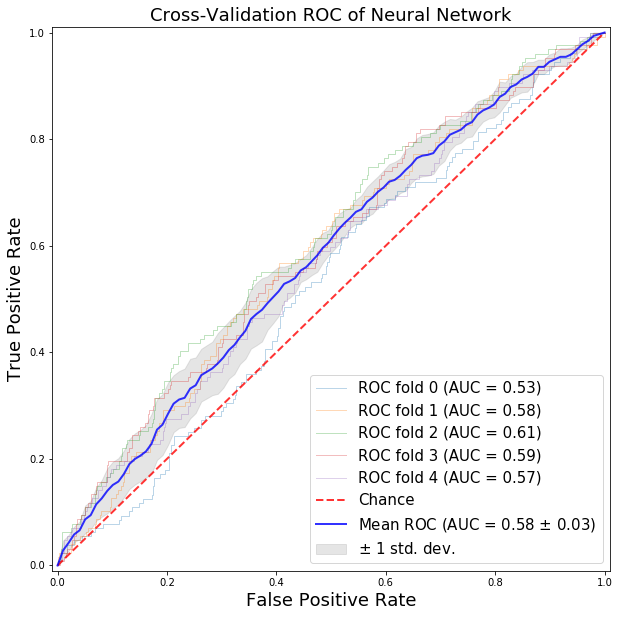

In [31]:
#plot the AUC for the best model

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold

protected_y = protected.loc[:,"Retained_High_Performer"]

X = mean_protected_X.values
Y = protected_y.values

cv = StratifiedKFold(n_splits=5)
classifier = MLPClassifier(hidden_layer_sizes = (120,), activation = "logistic", solver = "sgd", max_iter= 1000,random_state=0)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X, Y):
    probas_ = classifier.fit(X[train], Y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Neural Network',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

## NON-PROTECTED: Using 5-fold cross-validation on multiple models (5 Logistic Regression, 1 Naive Bayes, 1 Decision Tree, 6 Random Forests, 1 Support Vector Machine, 48 Neural Networks, 3 KNN models, and 1 XGBoost), find the best performing model for the Non-Protected group (across all three imputations) according to the AUC of the models.

In [12]:
# run models to predict for non-protected with median-, mean-, and KNN-imputed data
non_protected_y = non_protected.loc[:,"Retained_High_Performer"]

mean_non_protected= cross_validated_models(mean_non_protected_X, non_protected_y, 'Mean')

median_non_protected= cross_validated_models(median_non_protected_X, non_protected_y, 'Median')

KNN_non_protected= cross_validated_models(KNN_non_protected_X, non_protected_y, 'KNN')

# find and save best model from results

non_protected_results = pd.concat([mean_non_protected,median_non_protected,KNN_non_protected], ignore_index=True)

pd.set_option('display.max_colwidth',1000)
non_protected_results.sort_values(by=['ROC_AUC'], ascending=False).head(1)

non_protected_results.to_excel('non_protected_results.xlsx', index = False)
#from google.colab import files
#files.download('non_protected_results.xlsx')

# best model for non_protected: 
# KNN-imputed Neural Network with hidden_layer_sizes = (120,), activation = "logistic", solver = "sgd" (mean ROC AUC of 0.604)



B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\neural_

It ran!


B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\neural_

It ran!


B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\neural_

It ran!


## AUC Visualization

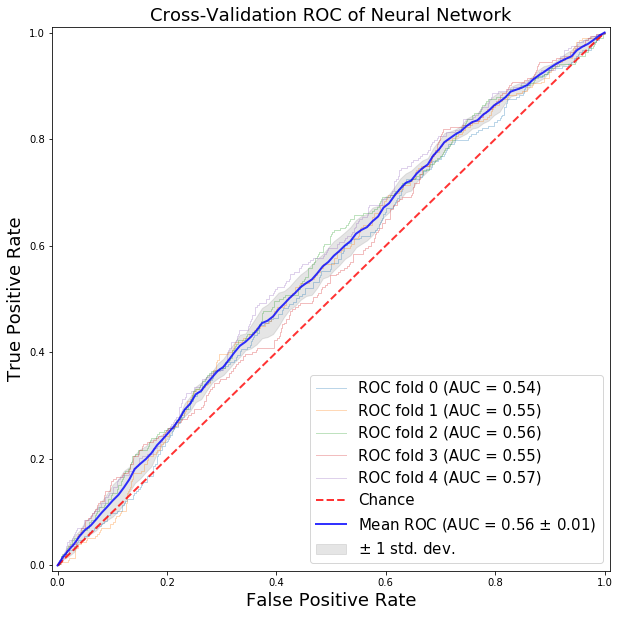

In [32]:
#plot the AUC for the best model

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold

non_protected_y = non_protected.loc[:,"Retained_High_Performer"]

X2 = KNN_non_protected_X.values
Y2 = non_protected_y.values

cv = StratifiedKFold(n_splits=5)
classifier = MLPClassifier(hidden_layer_sizes = (120,), activation = "logistic", solver = "sgd", max_iter= 1000)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X2, Y2):
    probas_ = classifier.fit(X2[train], Y2[train]).predict_proba(X2[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y2[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Neural Network',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

# Strategy 1: Create the Hire/Not Hire variable in the training dataset and then train the development dataset on that.




## PROTECTED: Use the top performing model to predict the probabilities of being a "Retained High Performer" for Protected training applicants.

In [13]:
# train the top performing model (with x normalized) and predict probabilities for training dataset (with x normalized)
from scipy.stats import zscore
from sklearn.neural_network import MLPClassifier

protected_y = protected.loc[:,"Retained_High_Performer"]
protected_predicted_proba = MLPClassifier(hidden_layer_sizes = (120,), activation = "logistic", solver = "sgd").fit(KNN_protected_X.apply(zscore), protected_y).predict_proba(KNN_protected_X.apply(zscore))

B:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [14]:
protected['Probability_of_Retained_High_Performer'] = pd.DataFrame(protected_predicted_proba)[1]

## NON-PROTECTED: Use the top performing model to predict the probabilities of being a "Retained High Performer" for Non-Protected training applicants.

In [15]:
# train the top performing model (with x normalized) and predict probabilities for training dataset (with x normalized)

non_protected_y = non_protected.loc[:,"Retained_High_Performer"]
non_protected_predicted_proba = MLPClassifier(hidden_layer_sizes = (120,), activation = "logistic", solver = "sgd").fit(mean_non_protected_X.apply(zscore), non_protected_y).predict_proba(mean_non_protected_X.apply(zscore))

In [16]:
non_protected['Probability_of_Retained_High_Performer'] = pd.DataFrame(non_protected_predicted_proba)[1]

## Organize the Protected training probabilities in ascending order and concatenate them onto the Non-Protected training probabilities organized in descending order

In [17]:
columns = ['UNIQUE_ID','High_Performer','Protected_Group','Retained','Retained_High_Performer','Probability_of_Retained_High_Performer']

protected_ascending = protected.sort_values(by=['Probability_of_Retained_High_Performer'], ascending = True).loc[:,columns]
non_protected_descending = non_protected.sort_values(by=['Probability_of_Retained_High_Performer'], ascending = False).loc[:,columns]

In [18]:
ordered_results = pd.concat([protected_ascending,non_protected_descending], ignore_index=True).reset_index()

## Use a for loop to go through all adjacent combinations of half of the training dataset (a training dataset of 7890 total applicants requires that 3945 applicants be hired), calculating adverse impact, true retained employees, true high perfomers, and true retained high performers, and then use these values to calculate the final score

In [19]:
# create dataframe with column for unfairness
protected_total = len(protected)
protected_list = list(ordered_results['Protected_Group'])
unfairness_list = [] 
for i in range(len(ordered_results)-3945):
    protected_identified = sum(protected_list[i:i+3945])
    protected_hire_rate = protected_identified/protected_total
    non_protected_hire_rate = (3945-protected_identified)/(7890-protected_total)
    unfairness = abs(1-(protected_hire_rate/non_protected_hire_rate))
    unfairness_list += [unfairness]

output = pd.DataFrame({'Unfairness':unfairness_list})

In [20]:
# create new column for percent high_performer identified 
high_performer_total = len(ordered_results[ordered_results['High_Performer']==1.0])
high_performer_list = list(ordered_results['High_Performer'])
high_performer_identified_list = [] 
for i in range(len(ordered_results)-3945):
    high_performer_identified = sum(high_performer_list[i:i+3945])/high_performer_total
    high_performer_identified_list += [high_performer_identified]

output['Percent_High_Performer']= high_performer_identified_list

In [21]:
# create new column for percent retained identified 
retained_total = len(ordered_results[ordered_results['Retained']==1])
retained_list = list(ordered_results['Retained'])
retained_identified_list = [] 
for i in range(len(ordered_results)-3945):
    retained_identified = sum(retained_list[i:i+3945])/retained_total
    retained_identified_list += [retained_identified]

output['Percent_Retained']= retained_identified_list

In [22]:
# create new column for percent retained_high_performer identified 
retained_high_performer_list = list(ordered_results['Retained_High_Performer'])
retained_high_performer_total = len(ordered_results[ordered_results['Retained_High_Performer']==1])
retained_high_performer_identified_list = [] 
for i in range(len(ordered_results)-3945):
    retained_high_performer_identified = sum(retained_high_performer_list[i:i+3945])/retained_high_performer_total
    retained_high_performer_identified_list += [retained_high_performer_identified]

output['Percent_Retained_High_Performer']=retained_high_performer_identified_list

In [23]:
# create column for final_score
output['Final_Score'] = 0.5*output['Percent_Retained_High_Performer']+0.25*output['Percent_Retained']+0.25*output['Percent_High_Performer']-output['Unfairness']

## Find the combination that results in the maximum final score and create a new "Hire" variable denoting that this half of applicants should be hired and the other half should not

In [24]:
# max final_score
max_index = output[output['Final_Score']==max(output['Final_Score'])].index
output.loc[max_index,:]

,Unfairness,Percent_High_Performer,Percent_Retained,Percent_Retained_High_Performer,Final_Score
1423,0.0,0.63456,0.52173,0.652979,0.615562


In [25]:
#  create a column called 'Hire' and fill it with 1s for the 3945 included in the max final_score distribution

hire=[]
for i in range(len(ordered_results)):
    if ((i > max_index) & (i <= max_index+3945)):
        hire += [1]
    else:
        hire += [0]

ordered_results['Hire'] = hire

## Return to the original training dataset that only contained instances with values for all three DVs ("Retained", "High_Performer", and "Protected_Group") but was not split by Protected_Group yet. Impute missing values with mean, median, and KNN with 10 neighbors (using knn.impute in the bnstruct package in R) to produce three different imputed datasets.

In [26]:
# impute features of Protected with mean, median, and KNN
training_X = training.loc[:, 'SJ_Most_1':'PScale13_Q5']

mean_training_X = training_X.fillna(training_X.mean())
median_training_X = training_X.fillna(training_X.median())

# training_X.to_excel('training_X_to_impute.xlsx', index = False)
# from google.colab import files
# files.download('training_X_to_impute.xlsx')

# this is the code I ran in R to impute KNN
# library(readxl)
# X_to_impute <- read_excel("training_X_to_impute.xlsx")
# library(bnstruct)
# KNN_X = knn.impute(as.matrix(X_to_impute), k= 10)
# library(writexl)
# write_xlsx(as.data.frame(KNN_X), "~/Desktop/SIOP Analysis/training_X_imputed.xlsx")

url_KNN_X = 'https://github.com/vl1146/SIOP2020ML/blob/master/training_X_imputed.xlsx?raw=true'

KNN_training_X= pd.read_excel(url_KNN_X)

## Using 5-fold cross-validation on multiple models (5 Logistic Regression, 1 Naive Bayes, 1 Decision Tree, 6 Random Forests, 1 Support Vector Machine, 48 Neural Networks, 3 KNN models, and 1 XGBoost), find the best performing model to predict the "Hire" variable across imputations according to the AUC of the models.

In [27]:
#hire_df = ordered_results[['UNIQUE_ID','Hire']]
# training_with_hire = pd.merge(training, hire_df, how='left', on='UNIQUE_ID')

# training_with_hire.to_excel('training_with_hire.xlsx', index= False)
# from google.colab import files
# files.download('training_with_hire.xlsx')

# can also start here by importing training with hire, but you'll still need to go one block above to impute training_X

url_training_with_hire = 'https://github.com/vl1146/SIOP2020ML/blob/master/training_with_hire.xlsx?raw=true'

training_with_hire= pd.read_excel(url_training_with_hire) 

In [28]:
# run models to predict Hire with median-, mean-, and KNN-imputed data
training_y = training_with_hire.loc[:,"Hire"]

mean_training= cross_validated_models(mean_training_X, training_y, 'Mean')

median_training= cross_validated_models(median_training_X, training_y, 'Median')

KNN_training= cross_validated_models(KNN_training_X, training_y, 'KNN')

# find and save best model from results

training_results = pd.concat([mean_training,median_training,KNN_training], ignore_index=True)

pd.set_option('display.max_colwidth',1000)
training_results.sort_values(by=['ROC_AUC'], ascending= False).head(1)

training_results.to_excel('training_results.xlsx', index = False)
#from google.colab import files
#files.download('training_results.xlsx')

# best model for non_protected: 
# median-imputed Neural Network with hidden_layer_sizes = (120,), activation= 'logistic', solver: 'adam' (mean ROC AUC of 0.862)


B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\neural_

It ran!


B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
B:\Anaconda\lib\site-packages\sklearn\neural_

KeyboardInterrupt: 

AUC

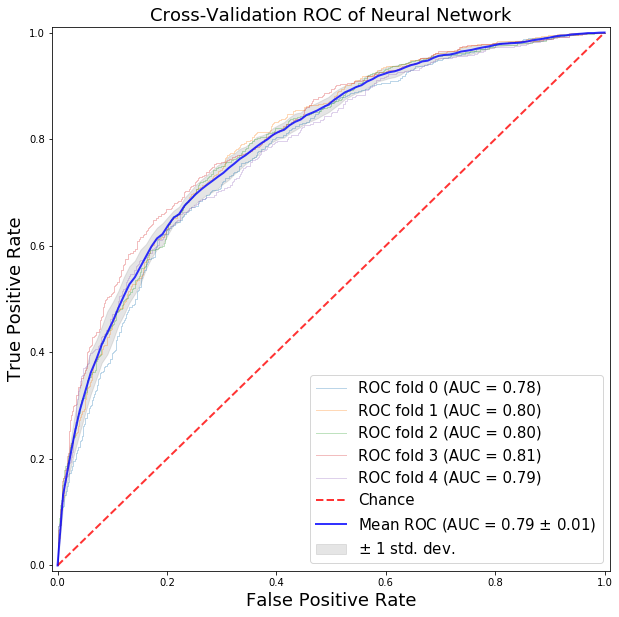

In [33]:
#plot the AUC for the best model

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold

training_y = training_with_hire.loc[:,"Hire"]

X = median_training_X.values
Y = training_y.values

cv = StratifiedKFold(n_splits=5)
classifier = MLPClassifier(hidden_layer_sizes = (120,), activation = "logistic", solver = "adam", max_iter= 1000,random_state=0)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X, Y):
    probas_ = classifier.fit(X[train], Y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Neural Network',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

## Import development dataset. Impute missing values according to the imputation of the best performing model. Predict the probability that each of these applicants is a Hire in a column called "Probability_of_Hire". Organize these probabilities in descending order. Create a new variable "Hire" which is 1 (hire) for the top half (a development dataset of 2250 total applicants requires that 1125 applicants be hired) and 0 (dont hire) for the bottom half

In [ ]:
# import non-imputed development data

url_participant_dev = 'https://github.com/vl1146/SIOP2020ML/blob/master/participant_dev.xlsx?raw=true' 

dev = pd.read_excel(url_participant_dev).drop('split', axis=1)

# impute features of development data with KNN
dev_X = dev.loc[:, 'SJ_Most_1':'PScale13_Q5']

mean_dev_X = dev_X.fillna(dev_X.mean())
median_dev_X = dev_X.fillna(dev_X.median())

# dev_X.to_excel('dev_X_to_impute.xlsx', index = False)
# from google.colab import files
# files.download('dev_X_to_impute.xlsx')

# this is the code I ran in R to impute KNN
# library(readxl)
# X_to_impute <- read_excel("dev_X_to_impute.xlsx")
# library(bnstruct)
# KNN_X = knn.impute(as.matrix(X_to_impute), k= 10)
# library(writexl)
# write_xlsx(as.data.frame(KNN_X), "~/Desktop/SIOP Analysis/dev_X_imputed.xlsx")

url_dev_x_imputed = ('https://github.com/vl1146/SIOP2020ML/blob/master/dev_X_imputed.xlsx?raw=true')

KNN_dev_X= pd.read_excel(url_dev_x_imputed)

In [ ]:
# train the top performing model (with x normalized) and predict probabilities for training dataset (with x normalized)
from scipy.stats import zscore

training_y = training_with_hire.loc[:,"Hire"]
dev_predicted_proba = MLPClassifier(hidden_layer_sizes = (120,), activation = 'logistic', solver= 'adam').fit(median_training_X.apply(zscore), training_y).predict_proba(median_dev_X.apply(zscore))

In [ ]:
dev['Probability_of_Hire'] = pd.DataFrame(dev_predicted_proba)[1]
dev_final = dev.sort_values(by=['Probability_of_Hire'], ascending = False)[['UNIQUE_ID','Probability_of_Hire']].reset_index()

In [ ]:
#  create a column called 'Hire' and fill it with 1s for the top 1125 instances
dev_final['Hire']= [1 if row < 1125 else 0 for row in range(len(dev_final))]
final= dev_final[['UNIQUE_ID','Hire']]

## Submit a dataframe with just "UNIQUE_ID" and "Hire". Submit it to the competition organizers and post the prediction metrics here

In [ ]:
final.to_csv('final_strategy_1.csv', index = False)


In [ ]:
# Results from organizers:
{"Percentage_of_true_top_performers_hired": 0.457, 
 "Percentage_of_true_retained_hired": 0.572, 
 "Percentage_of_true_retained_top_performers_hired": 0.455, 
 "Adverse_impact_ratio": 0.9771, 
 "Final_score": 46.1747}

# Strategy 2: Use the top performing models for the training dataset to predict the probabilities of "Retained High Performer" in the development dataset. Then use those probabilities to determine who should be hired.

## Using 5-fold cross-validation on multiple models (5 Logistic Regression, 1 Naive Bayes, 1 Decision Tree, 6 Random Forests, 1 Support Vector Machine, 48 Neural Networks, 3 KNN models, and 1 XGBoost), find the best performing model to predict the "Protected_Group" variable in the training dataset across imputations according to the AUC of the models.

In [ ]:
# run models to predict Hire with median-, mean-, and KNN-imputed data
training_y = training_with_hire.loc[:,"Protected_Group"]

mean_training= cross_validated_models(mean_training_X, training_y, 'Mean')

median_training= cross_validated_models(median_training_X, training_y, 'Median')

KNN_training= cross_validated_models(KNN_training_X, training_y, 'KNN')

#find and save the best performing model

training_protected_results = pd.concat([mean_training,median_training,KNN_training], ignore_index=True)

pd.set_option('display.max_colwidth',1000)
training_protected_results.sort_values(by=['ROC_AUC'], ascending= False).head(1)

training_protected_results.to_excel('training_protected_results.xlsx', index = False)
#from google.colab import files
#files.download('training_protected_results.xlsx')

# best model for non_protected: 
# KNN-imputed Random Foest with n_estimators = 250 (mean OC AUC of 0.714)


AUC

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


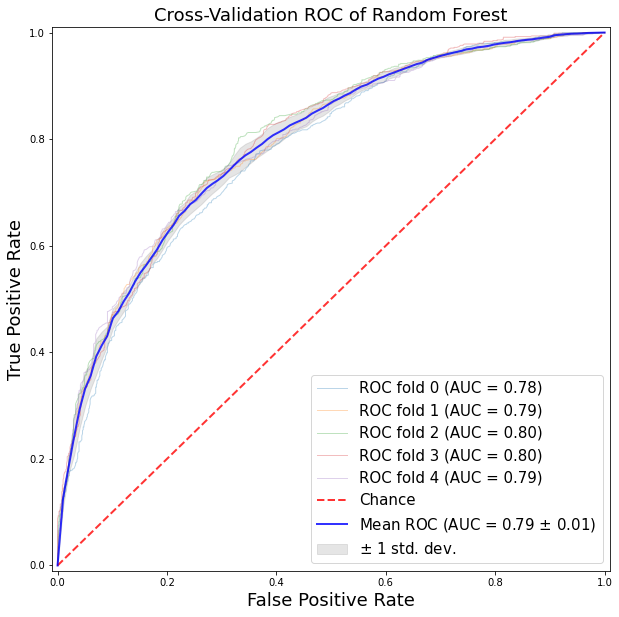

In [0]:
#plot the AUC for the best model

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier as rfc

training_y = training_with_hire.loc[:,"Hire"]

X = KNN_training_X.values
Y = training_y.values

cv = StratifiedKFold()
classifier = rfc(n_estimators=1500, max_features="log2", random_state=0)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X, Y):
    probas_ = classifier.fit(X[train], Y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Random Forest',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

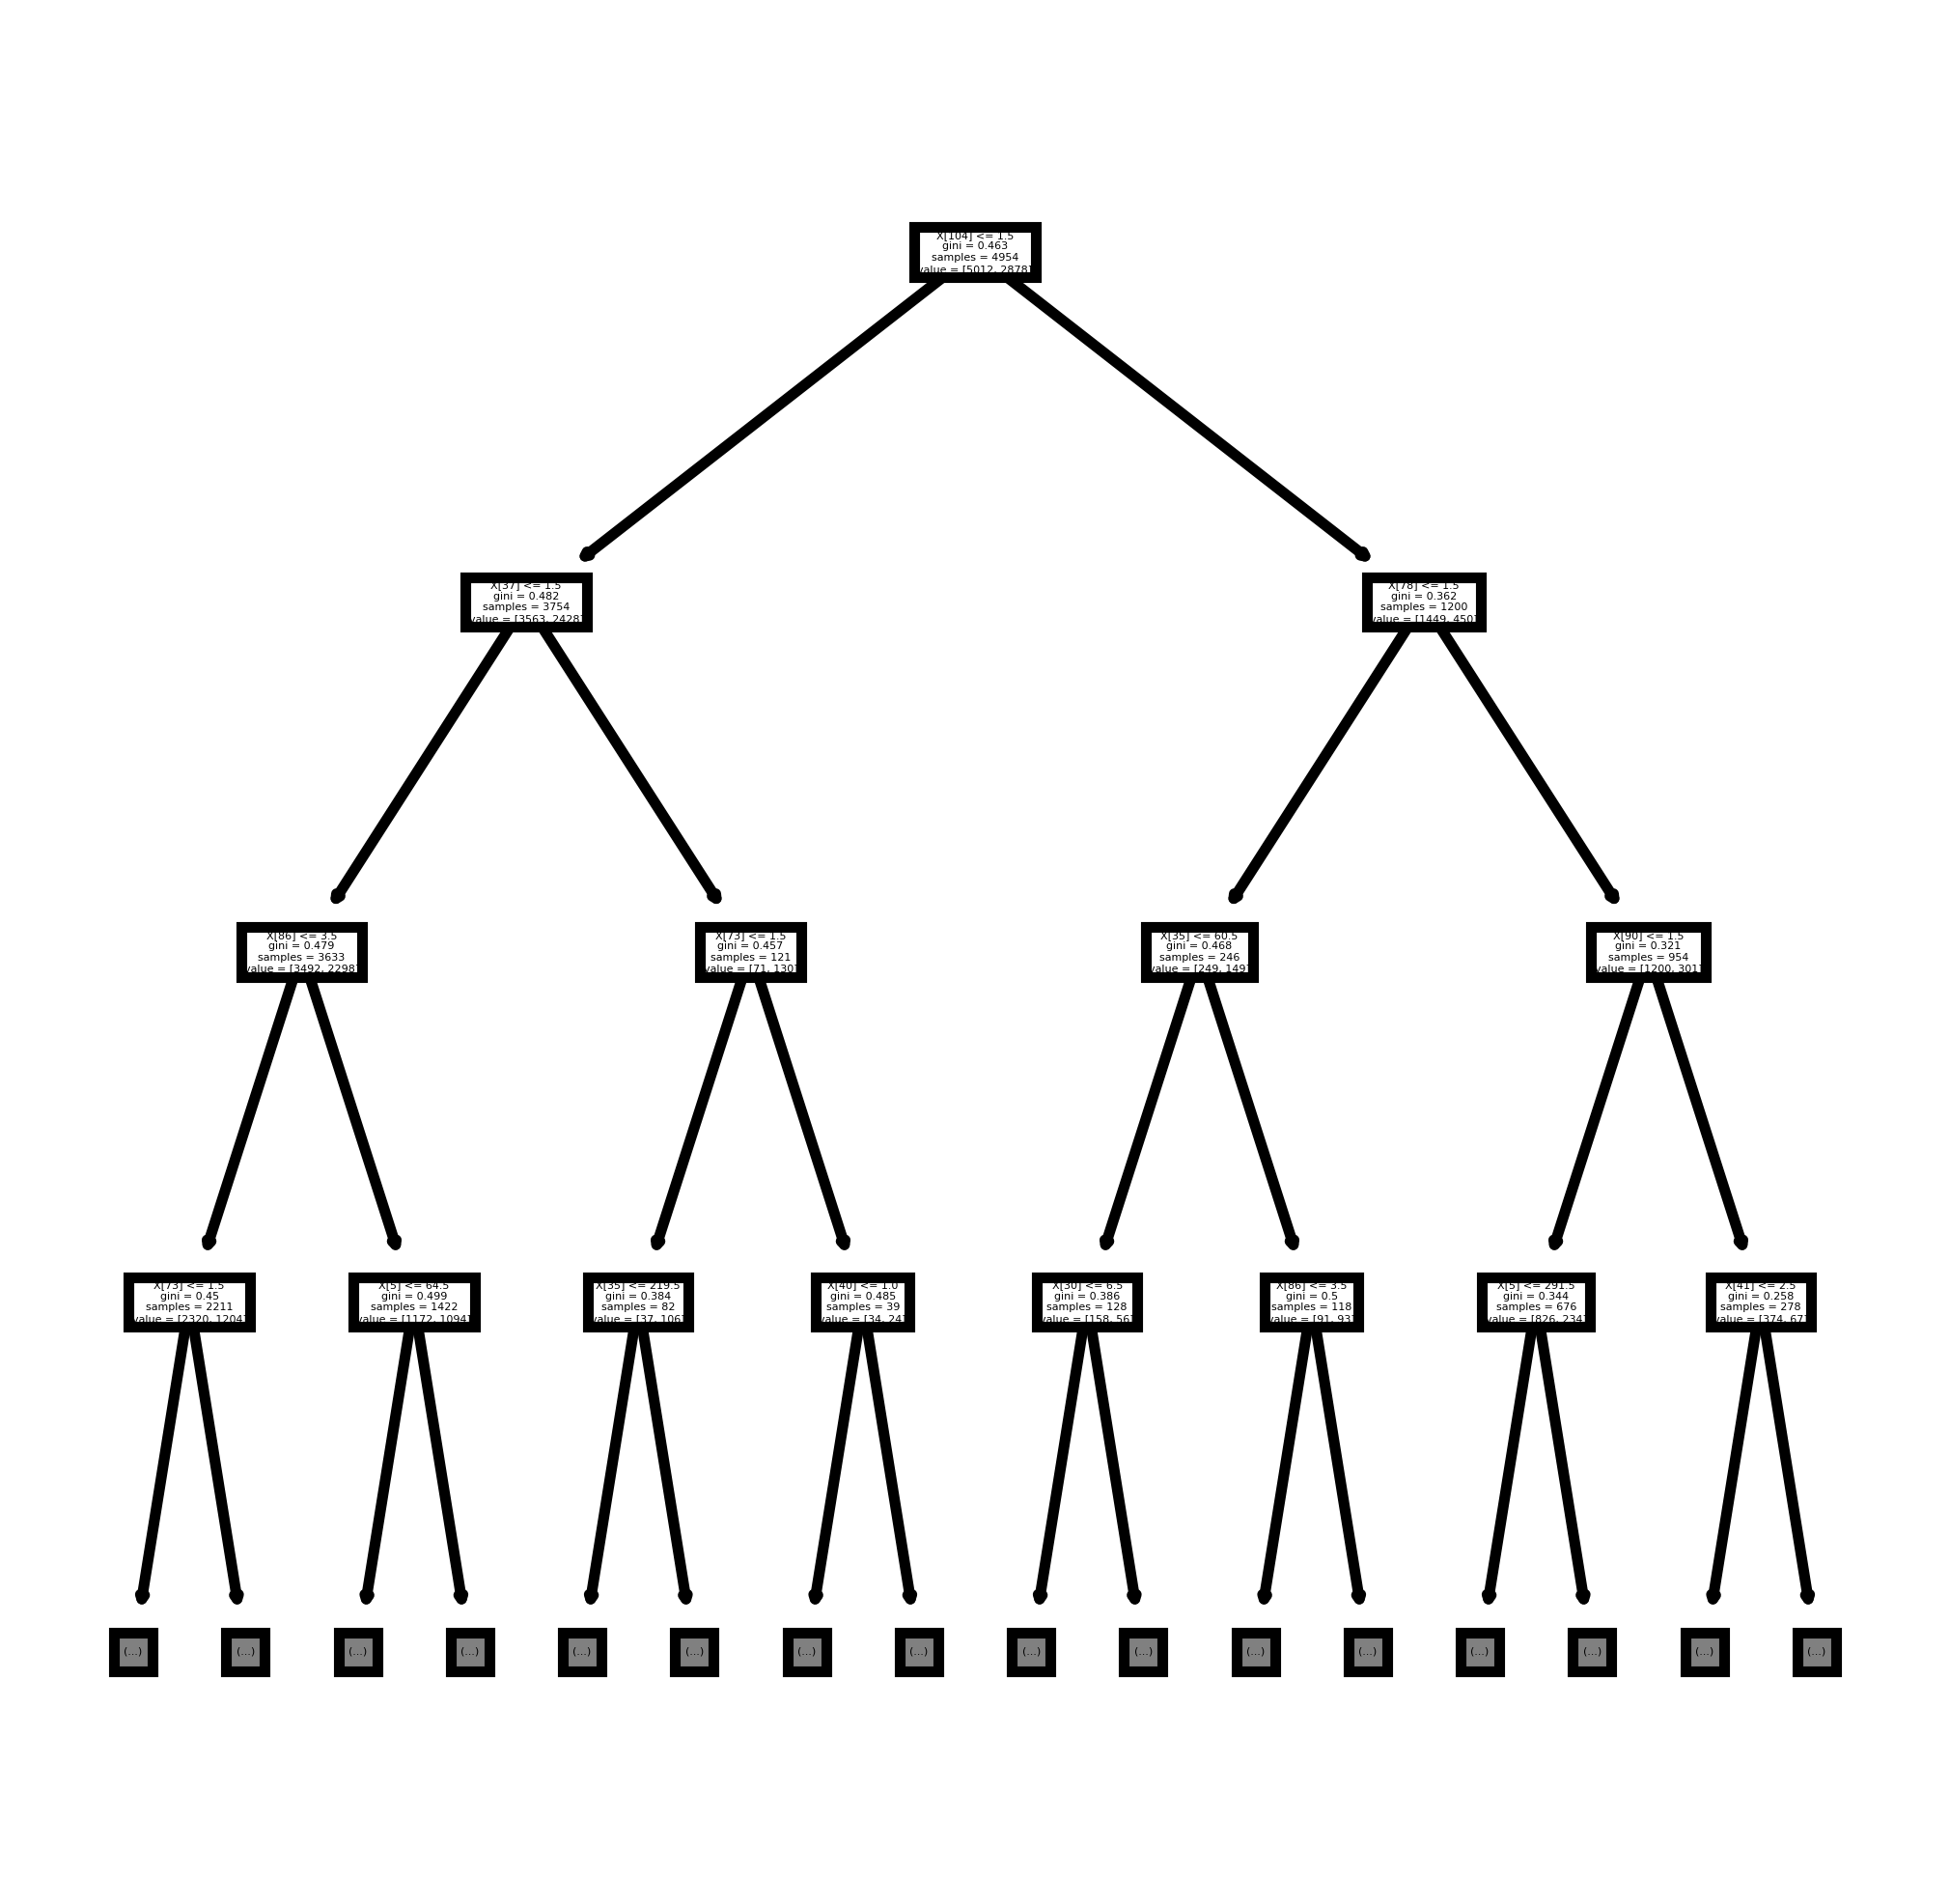

In [34]:
import matplotlib.pyplot as plt
from sklearn import tree
import pandas as pd
from sklearn.model_selection import cross_validate
from scipy.stats import zscore
from sklearn.ensemble import RandomForestClassifier as rfc

url_training_with_hire = 'https://github.com/vl1146/SIOP2020ML/blob/master/training_with_hire.xlsx?raw=true'
training_with_hire= pd.read_excel(url_training_with_hire) 

training_y = training_with_hire.loc[:,"Protected_Group"]

df = pd.DataFrame(data = training_with_hire)
df['Hire'] = training_with_hire.Hire

rf = rfc(n_estimators=1500, max_features="log2", random_state=0)
rf.fit(KNN_training_X, training_y)

#fn= df.loc[:, df.columns !='Hire']
#cn= df.loc[:, 'Hire']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi=800)
tree.plot_tree(rf.estimators_[0],
              max_depth = 3);
fig.savefig('rf_individualtree.png')


## Import development dataset and predict "Protected_Group" based on top performing model

In [ ]:
training_y = training_with_hire.loc[:,"Protected_Group"]
KNN_dev_protected_group = rfc(n_estimators= 250).fit(KNN_training_X.apply(zscore), training_y).predict(KNN_dev_X.apply(zscore))
dev['Predicted_Protected_Group'] = KNN_dev_protected_group

## Split development dataset based on predicted "Protected_Group"

In [ ]:
dev_protected = dev[dev['Predicted_Protected_Group']==1].reset_index()
dev_non_protected = dev[dev['Predicted_Protected_Group']==0].reset_index()

## PROTECTED: Impute and predict probabilities of being "Retained High Performer" for the Protected development group based on the best performing model for the Protected training group.

In [ ]:
# best model for non_protected: mean-imputed Neural Network with hidden_layer_sizes = (120,), activation = "logistic", solver = "sgd"

# impute features of development protected data with KNN
dev_protected_X = dev_protected.loc[:, 'SJ_Most_1':'PScale13_Q5']

mean_dev_protected_X = dev_protected_X.fillna(dev_protected_X.mean())

In [ ]:
# train the top performing model (with x normalized) and predict probabilities for training dataset (with x normalized)
protected_y = protected.loc[:,"Retained_High_Performer"]

dev_protected['Probability_of_Retained_High_Performer']= pd.DataFrame(MLPClassifier(hidden_layer_sizes = (120,), activation = "logistic", solver = "sgd").fit(mean_protected_X.apply(zscore), protected_y).predict_proba(mean_dev_protected_X.apply(zscore)))[1]

## NON-PROTECTED: Impute and predict probabilities of being "Retained High Performer" for the Non-Protected development group based on the best performing model for the Non-Protected training group.

In [ ]:
# best model for non_protected: KNN-imputed Neural Network with hidden_layer_sizes = (120,), activation = "logistic", solver = "sgd"

dev_non_protected_X = dev_non_protected.loc[:, 'SJ_Most_1':'PScale13_Q5']

# dev_non_protected_X.to_excel('dev_non_protected_X_to_impute.xlsx', index = False)
# from google.colab import files
# files.download('dev_non_protected_X_to_impute.xlsx')

# this is the code I ran in R to impute KNN
# library(readxl)
# X_to_impute <- read_excel('dev_non_protected_X_to_impute.xlsx')
# library(bnstruct)
# KNN_X = knn.impute(as.matrix(X_to_impute), k= 10)
# library(writexl)
# write_xlsx(as.data.frame(KNN_X), "~/Desktop/SIOP Analysis/dev_non_protected_X_imputed.xlsx')

url_dev_non_protected_X= 'https://github.com/vl1146/SIOP2020ML/blob/master/dev_non_protected_X_imputed.xlsx?raw=true'

KNN_dev_non_protected_X= pd.read_excel(url_dev_non_protected_X)

In [ ]:
# train the top performing model (with x normalized) and predict probabilities for training dataset (with x normalized)
non_protected_y = non_protected.loc[:,"Retained_High_Performer"]

dev_non_protected_predict_proba = MLPClassifier(hidden_layer_sizes = (120,), activation = "logistic", solver = "sgd").fit(KNN_non_protected_X.apply(zscore), non_protected_y).predict_proba(KNN_dev_non_protected_X.apply(zscore)) 

dev_non_protected['Probability_of_Retained_High_Performer']= pd.DataFrame(dev_non_protected_predict_proba)[1]

## Organize the Protected development probabilities in ascending order and concatenate them onto the Non-Protected development probabilities organized in descending order.



In [ ]:
columns = ['UNIQUE_ID','Predicted_Protected_Group','Probability_of_Retained_High_Performer']

dev_protected_ascending = dev_protected.sort_values(by=['Probability_of_Retained_High_Performer'], ascending = True).loc[:,columns]
dev_non_protected_descending = dev_non_protected.sort_values(by=['Probability_of_Retained_High_Performer'], ascending = False).loc[:,columns]

In [ ]:
ordered_results = pd.concat([dev_protected_ascending,dev_non_protected_descending], ignore_index=True).reset_index()

## Hire proportional numbers of development Protected and Non-Protected applicants based on how many Protected (416) and Non-Protected (1834) were predicted

In [ ]:
# create dataframe with column for unfairness
dev_protected_total = len(dev_protected)
dev_protected_list = list(ordered_results['Predicted_Protected_Group'])
unfairness_list = [] 
for i in range(len(ordered_results)-1125):
    dev_protected_identified = sum(dev_protected_list[i:i+1125])
    dev_protected_hire_rate = dev_protected_identified/dev_protected_total
    dev_non_protected_hire_rate = (1125-dev_protected_identified)/(2250-dev_protected_total)
    unfairness = abs(1-dev_protected_hire_rate/dev_non_protected_hire_rate)
    unfairness_list += [unfairness]

output = pd.DataFrame({'Unfairness':unfairness_list})

In [ ]:
# create new column for total probability of retained_high_performer
retained_high_performer_list = list(ordered_results['Probability_of_Retained_High_Performer'])
retained_high_performer_identified_list = [] 
for i in range(len(ordered_results)-1125):
    retained_high_performer_identified = sum(retained_high_performer_list[i:i+1125])
    retained_high_performer_identified_list += [retained_high_performer_identified]

output['Total_Probability_of_Retained_High_Performer']=retained_high_performer_identified_list

In [ ]:
output['Score']= output['Total_Probability_of_Retained_High_Performer']-abs(output['Unfairness'])*output['Total_Probability_of_Retained_High_Performer']

## Find the combination that results in the maximum final score and create a new "Hire" variable denoting that this half of applicants should be hired and the other half should not

In [ ]:
max_index = output[output['Score']==output['Score'].max()].index

In [ ]:
#  create a column called 'Hire' and fill it with 1s for the 1125 included in the max Score distribution

hire=[]
for i in range(len(ordered_results)):
    if ((i >= max_index) & (i < (max_index+1125))):
        hire += [1]
    else:
        hire += [0]

ordered_results['Hire'] = hire

In [ ]:
ordered_results['Hire'].value_counts()

## Submit a dataframe with just "UNIQUE_ID" and "Hire". Submit it to the competition organizers and post the prediction metrics here.

In [ ]:
final= ordered_results[['UNIQUE_ID','Hire']]
final.to_csv('final_strategy_2.csv', index = False)
#from google.colab import files
#files.download('final_strategy_2.csv')

In [ ]:
# results from organizers:

{"Percentage_of_true_top_performers_hired": 0.613, 
 "Percentage_of_true_retained_hired": 0.566, 
 "Percentage_of_true_retained_top_performers_hired": 0.605, 
 "Adverse_impact_ratio": 1.0312, 
 "Final_score": 56.5861}